In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'fr'
target_lang = 'fr'
model_size = '7b'
prefix = "./data/langs/"
type = 'logit'

In [4]:
# Parameters
model_size = "7b"
target_lang = "en"
input_lang = "en"
type = "tuned"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()
llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
    
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

params.pt AlignmentResearch/tuned-lens space main lens/meta-llama/Llama-2-7b-hf None


params.pt:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

(…)ens/meta-llama/Llama-2-7b-hf/config.json:   0%|          | 0.00/258 [00:00<?, ?B/s]

In [6]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=4096, out_features=32000, bias=False)
)
U torch.Size([32000, 4096]) weights torch.Size([1, 4096])


0.058621685951948166


In [7]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    df_en_target_input.rename(columns={'word_original': 'en', 
                                f'word_translation': target_lang if target_lang != 'en' else 'en_tgt'}, 
                                inplace=True)
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    df_en_target_input.rename(columns={'word_original': 'en', 
                                f'word_translation_{target_lang}': target_lang if target_lang != 'en' else 'en_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != 'en' else 'en_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != 'en':
    for i, row in df_en_target_input.iterrows():
        if row['en'].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_en_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for en 132 of 132 are single tokens
final length of df_en_en_en: 132


In [8]:
df_en_target_input

,lang,en,en_tgt,blank_prompt_original,blank_prompt_translation,blank_prompt_translation_masked,error
0,en,book,book,"A ""book"" is used to read stories. Answer: ""book"".","A ""book"" is used to read stories. Answer: ""book"".","A ""___"" is used to read stories. Answer: ""book"".",no error
1,en,cloud,cloud,"A ""cloud"" is a visible mass of condensed water...","A ""cloud"" is a visible mass of condensed water...","A ""___"" is a visible mass of condensed water v...",no error
2,en,bag,bag,"A ""bag"" is used to carry items. Answer: ""bag"".","A ""bag"" is used to carry items. Answer: ""bag"".","A ""___"" is used to carry items. Answer: ""bag"".",no error
3,en,mouth,mouth,"A ""mouth"" is used to eat food and speak. Answe...","A ""mouth"" is used to eat food and speak. Answe...","A ""___"" is used to eat food and speak. Answer:...",no error
4,en,soil,soil,"""A ""soil"" is used for planting trees and crops...","""A ""soil"" is used for planting trees and crops...","""A ""___"" is used for planting trees and crops....",no error
...,...,...,...,...,...,...,...
127,en,rise,rise,"""A ""rise"" is used to describe an increase or u...","""A ""rise"" is used to describe an increase or u...","""A ""___"" is used to describe an increase or up...",no error
128,en,left,left,"'A ""left"" is a direction opposite to right. An...","'A ""left"" is a direction opposite to right. An...","'A ""___"" is a direction opposite to right. Ans...",no error
129,en,sound,sound,"A ""sound"" is something we hear. Answer: ""sound"".","A ""sound"" is something we hear. Answer: ""sound"".","A ""___"" is something we hear. Answer: ""sound"".",no error
130,en,power,power,"""A ""power"" is used to control or influence peo...","""A ""power"" is used to control or influence peo...","""A ""___"" is used to control or influence peopl...",no error


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != 'en' and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                       | 0/132 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                                                                                             | 1/132 [00:00<00:24,  5.43it/s]

  2%|███▏                                                                                                                                                                                                           | 2/132 [00:00<00:28,  4.55it/s]

  2%|████▋                                                                                                                                                                                                          | 3/132 [00:00<00:24,  5.25it/s]

  3%|██████▎                                                                                                                                                                                                        | 4/132 [00:00<00:25,  4.96it/s]

  4%|███████▊                                                                                                                                                                                                       | 5/132 [00:00<00:24,  5.29it/s]

  5%|█████████▍                                                                                                                                                                                                     | 6/132 [00:01<00:28,  4.36it/s]

  5%|██████████▉                                                                                                                                                                                                    | 7/132 [00:01<00:28,  4.44it/s]

  6%|████████████▌                                                                                                                                                                                                  | 8/132 [00:01<00:27,  4.45it/s]

  7%|██████████████                                                                                                                                                                                                 | 9/132 [00:01<00:27,  4.51it/s]

  8%|███████████████▌                                                                                                                                                                                              | 10/132 [00:02<00:24,  4.97it/s]

  8%|█████████████████▏                                                                                                                                                                                            | 11/132 [00:02<00:24,  4.92it/s]

  9%|██████████████████▋                                                                                                                                                                                           | 12/132 [00:02<00:26,  4.50it/s]

 10%|████████████████████▎                                                                                                                                                                                         | 13/132 [00:02<00:24,  4.77it/s]

 11%|█████████████████████▊                                                                                                                                                                                        | 14/132 [00:02<00:23,  4.97it/s]

 11%|███████████████████████▍                                                                                                                                                                                      | 15/132 [00:03<00:27,  4.21it/s]

 12%|████████████████████████▉                                                                                                                                                                                     | 16/132 [00:03<00:28,  4.01it/s]

 13%|██████████████████████████▌                                                                                                                                                                                   | 17/132 [00:03<00:26,  4.28it/s]

 14%|████████████████████████████                                                                                                                                                                                  | 18/132 [00:03<00:25,  4.54it/s]

 14%|█████████████████████████████▋                                                                                                                                                                                | 19/132 [00:04<00:24,  4.61it/s]

 15%|███████████████████████████████▏                                                                                                                                                                              | 20/132 [00:04<00:24,  4.54it/s]

 16%|████████████████████████████████▊                                                                                                                                                                             | 21/132 [00:04<00:23,  4.69it/s]

 17%|██████████████████████████████████▎                                                                                                                                                                           | 22/132 [00:04<00:22,  4.80it/s]

 17%|███████████████████████████████████▉                                                                                                                                                                          | 23/132 [00:04<00:24,  4.51it/s]

 18%|█████████████████████████████████████▍                                                                                                                                                                        | 24/132 [00:05<00:21,  4.93it/s]

 19%|███████████████████████████████████████                                                                                                                                                                       | 25/132 [00:05<00:21,  5.06it/s]

 20%|████████████████████████████████████████▌                                                                                                                                                                     | 26/132 [00:05<00:21,  4.96it/s]

 20%|██████████████████████████████████████████▏                                                                                                                                                                   | 27/132 [00:05<00:20,  5.08it/s]

 21%|███████████████████████████████████████████▋                                                                                                                                                                  | 28/132 [00:05<00:18,  5.51it/s]

 22%|█████████████████████████████████████████████▎                                                                                                                                                                | 29/132 [00:06<00:19,  5.34it/s]

 23%|██████████████████████████████████████████████▊                                                                                                                                                               | 30/132 [00:06<00:21,  4.73it/s]

 23%|████████████████████████████████████████████████▍                                                                                                                                                             | 31/132 [00:06<00:21,  4.63it/s]

 24%|█████████████████████████████████████████████████▉                                                                                                                                                            | 32/132 [00:06<00:22,  4.54it/s]

 25%|███████████████████████████████████████████████████▌                                                                                                                                                          | 33/132 [00:07<00:24,  4.01it/s]

 26%|█████████████████████████████████████████████████████                                                                                                                                                         | 34/132 [00:07<00:23,  4.16it/s]

 27%|██████████████████████████████████████████████████████▌                                                                                                                                                       | 35/132 [00:07<00:25,  3.86it/s]

 27%|████████████████████████████████████████████████████████▏                                                                                                                                                     | 36/132 [00:07<00:27,  3.55it/s]

 28%|█████████████████████████████████████████████████████████▋                                                                                                                                                    | 37/132 [00:08<00:24,  3.83it/s]

 29%|███████████████████████████████████████████████████████████▎                                                                                                                                                  | 38/132 [00:08<00:22,  4.09it/s]

 30%|████████████████████████████████████████████████████████████▊                                                                                                                                                 | 39/132 [00:08<00:28,  3.22it/s]

 30%|██████████████████████████████████████████████████████████████▍                                                                                                                                               | 40/132 [00:09<00:26,  3.53it/s]

 31%|███████████████████████████████████████████████████████████████▉                                                                                                                                              | 41/132 [00:09<00:27,  3.34it/s]

 32%|█████████████████████████████████████████████████████████████████▌                                                                                                                                            | 42/132 [00:09<00:24,  3.67it/s]

 33%|███████████████████████████████████████████████████████████████████                                                                                                                                           | 43/132 [00:09<00:22,  3.89it/s]

 33%|████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 44/132 [00:10<00:20,  4.26it/s]

 34%|██████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 45/132 [00:10<00:19,  4.56it/s]

 35%|███████████████████████████████████████████████████████████████████████▊                                                                                                                                      | 46/132 [00:10<00:17,  4.87it/s]

 36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 47/132 [00:10<00:18,  4.67it/s]

 36%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 48/132 [00:10<00:16,  5.07it/s]

 37%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                                 | 49/132 [00:10<00:15,  5.37it/s]

 38%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                | 50/132 [00:11<00:16,  4.96it/s]

 39%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 51/132 [00:11<00:16,  4.98it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 52/132 [00:11<00:15,  5.11it/s]

 40%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                                           | 53/132 [00:11<00:14,  5.41it/s]

 41%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                         | 54/132 [00:11<00:14,  5.31it/s]

 42%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                        | 55/132 [00:12<00:15,  5.12it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 56/132 [00:12<00:14,  5.21it/s]

 43%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                     | 57/132 [00:12<00:13,  5.52it/s]

 44%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                   | 58/132 [00:12<00:13,  5.50it/s]

 45%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 59/132 [00:12<00:13,  5.38it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                | 60/132 [00:13<00:14,  4.90it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                              | 61/132 [00:13<00:16,  4.37it/s]

 47%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 62/132 [00:13<00:15,  4.48it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                           | 63/132 [00:13<00:13,  5.10it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                          | 64/132 [00:13<00:13,  4.91it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 65/132 [00:14<00:13,  4.95it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 66/132 [00:14<00:13,  4.80it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                     | 67/132 [00:14<00:13,  4.79it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 68/132 [00:14<00:12,  4.97it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                  | 69/132 [00:14<00:12,  5.09it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                | 70/132 [00:15<00:12,  4.80it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                               | 71/132 [00:15<00:14,  4.24it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 72/132 [00:15<00:14,  4.27it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 73/132 [00:16<00:15,  3.88it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 74/132 [00:16<00:14,  4.10it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                         | 75/132 [00:16<00:14,  3.81it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 76/132 [00:16<00:15,  3.56it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 77/132 [00:17<00:16,  3.34it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 78/132 [00:17<00:16,  3.33it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 79/132 [00:17<00:15,  3.44it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 80/132 [00:18<00:14,  3.54it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 81/132 [00:18<00:13,  3.65it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 82/132 [00:18<00:12,  3.93it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 83/132 [00:18<00:12,  4.05it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 84/132 [00:19<00:12,  3.93it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 85/132 [00:19<00:14,  3.34it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 86/132 [00:19<00:11,  3.93it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 87/132 [00:19<00:11,  3.81it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 88/132 [00:20<00:10,  4.06it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 89/132 [00:20<00:10,  3.94it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 90/132 [00:20<00:10,  4.19it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 91/132 [00:20<00:10,  3.95it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 92/132 [00:21<00:09,  4.02it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 93/132 [00:21<00:09,  3.97it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 94/132 [00:21<00:09,  4.02it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 95/132 [00:21<00:10,  3.66it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 96/132 [00:22<00:09,  3.82it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 97/132 [00:22<00:08,  4.34it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 98/132 [00:22<00:08,  4.12it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 99/132 [00:22<00:08,  3.75it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 100/132 [00:23<00:08,  3.73it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 101/132 [00:23<00:08,  3.76it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 102/132 [00:23<00:09,  3.24it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 103/132 [00:24<00:08,  3.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 104/132 [00:24<00:07,  3.58it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 105/132 [00:24<00:07,  3.77it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 106/132 [00:24<00:06,  4.04it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 107/132 [00:25<00:06,  3.65it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 108/132 [00:25<00:06,  3.82it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 109/132 [00:25<00:05,  3.84it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 110/132 [00:25<00:05,  3.80it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 111/132 [00:26<00:05,  3.66it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 112/132 [00:26<00:05,  3.72it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 113/132 [00:26<00:04,  4.12it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 114/132 [00:26<00:04,  4.04it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 115/132 [00:27<00:03,  4.39it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 116/132 [00:27<00:03,  4.23it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 117/132 [00:27<00:03,  4.18it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 118/132 [00:27<00:03,  4.22it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 119/132 [00:27<00:02,  4.47it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 120/132 [00:28<00:02,  4.74it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 121/132 [00:28<00:02,  3.94it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 122/132 [00:28<00:02,  3.81it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 123/132 [00:29<00:02,  3.62it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 124/132 [00:29<00:02,  3.45it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 125/132 [00:29<00:01,  3.57it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 126/132 [00:29<00:01,  3.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 127/132 [00:30<00:01,  3.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 128/132 [00:30<00:00,  4.17it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 129/132 [00:30<00:00,  4.42it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 130/132 [00:30<00:00,  4.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 131/132 [00:30<00:00,  4.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:31<00:00,  4.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:31<00:00,  4.23it/s]

In [12]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [13]:
df

,prompt,out_token_id,out_token_str,latent_token_id,latent_token_str,in_token_str
0,"English: ""ten"" - English: ""ten""\nEnglish: ""tea...","[833, 1045, 289, 3143, 29890, 2909]",book,"[833, 1045, 289, 3143, 29890, 2909]",book,book
1,"English: ""hundred"" - English: ""hundred""\nEngli...","[274, 23642, 695, 29883, 1067, 9274, 9570, 151...",cloud,"[274, 23642, 695, 29883, 1067, 9274, 9570, 151...",cloud,cloud
2,"English: ""ground"" - English: ""ground""\nEnglish...","[19548, 2291, 9922, 289, 23156, 29890]",bag,"[19548, 2291, 9922, 289, 23156, 29890]",bag,bag
3,"English: ""point"" - English: ""point""\nEnglish: ...","[2730, 286, 13394, 29442, 21026, 4346, 29885]",mouth,"[2730, 286, 13394, 29442, 21026, 4346, 29885]",mouth,mouth
4,"English: ""middle"" - English: ""middle""\nEnglish...","[269, 29879, 22473, 578, 577]",soil,"[269, 29879, 22473, 578, 577]",soil,soil
...,...,...,...,...,...,...
127,"English: ""structure"" - English: ""structure""\nE...","[5161, 10107, 364, 14451, 3780, 29878, 374]",rise,"[5161, 10107, 364, 14451, 3780, 29878, 374]",rise,rise
128,"English: ""structure"" - English: ""structure""\nE...","[454, 2175, 301, 280, 25874, 1563, 29880]",left,"[454, 2175, 301, 280, 25874, 1563, 29880]",left,left
129,"English: ""rock"" - English: ""rock""\nEnglish: ""g...","[269, 6047, 29879, 29802, 3669, 578, 577]",sound,"[269, 6047, 29879, 29802, 3669, 578, 577]",sound,sound
130,"English: ""two"" - English: ""two""\nEnglish: ""tai...","[13519, 1129, 772, 29886, 12248, 3081, 4764, 282]",power,"[13519, 1129, 772, 29886, 12248, 3081, 4764, 282]",power,power


In [14]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    for i in range(32):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [15]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.35it/s]

2it [00:00,  2.50it/s]

3it [00:01,  3.32it/s]

4it [00:01,  4.19it/s]

5it [00:01,  4.66it/s]

6it [00:01,  4.28it/s]

7it [00:01,  4.45it/s]

8it [00:02,  4.68it/s]

9it [00:02,  4.73it/s]

10it [00:02,  5.05it/s]

11it [00:02,  5.20it/s]

12it [00:02,  5.22it/s]

13it [00:02,  5.57it/s]

14it [00:03,  5.86it/s]

15it [00:03,  5.92it/s]

16it [00:03,  6.09it/s]

17it [00:03,  6.29it/s]

18it [00:03,  6.36it/s]

19it [00:03,  6.30it/s]

20it [00:04,  6.32it/s]

21it [00:04,  6.39it/s]

22it [00:04,  6.42it/s]

23it [00:04,  6.48it/s]

24it [00:04,  6.47it/s]

25it [00:04,  6.33it/s]

26it [00:05,  6.13it/s]

27it [00:05,  6.21it/s]

28it [00:05,  6.19it/s]

29it [00:05,  6.34it/s]

30it [00:05,  6.38it/s]

31it [00:05,  6.36it/s]

32it [00:05,  6.25it/s]

33it [00:06,  6.52it/s]

34it [00:06,  6.55it/s]

35it [00:06,  5.97it/s]

36it [00:06,  6.03it/s]

37it [00:06,  5.92it/s]

38it [00:06,  5.93it/s]

39it [00:07,  5.93it/s]

40it [00:07,  5.43it/s]

41it [00:07,  5.47it/s]

42it [00:07,  5.78it/s]

43it [00:07,  5.26it/s]

44it [00:08,  5.38it/s]

45it [00:08,  5.74it/s]

46it [00:08,  5.48it/s]

47it [00:08,  5.71it/s]

48it [00:08,  5.40it/s]

49it [00:09,  5.17it/s]

50it [00:09,  5.25it/s]

51it [00:09,  4.90it/s]

52it [00:09,  5.34it/s]

53it [00:09,  5.73it/s]

54it [00:09,  5.73it/s]

55it [00:10,  5.50it/s]

56it [00:10,  5.41it/s]

57it [00:10,  5.55it/s]

58it [00:10,  5.37it/s]

59it [00:10,  5.60it/s]

60it [00:10,  5.75it/s]

61it [00:11,  5.19it/s]

62it [00:11,  5.30it/s]

63it [00:11,  5.25it/s]

64it [00:11,  5.24it/s]

65it [00:11,  5.19it/s]

66it [00:12,  4.97it/s]

67it [00:12,  5.03it/s]

68it [00:12,  5.33it/s]

69it [00:12,  5.48it/s]

70it [00:12,  5.88it/s]

71it [00:13,  6.16it/s]

72it [00:13,  5.93it/s]

73it [00:13,  5.75it/s]

74it [00:13,  6.20it/s]

75it [00:13,  5.89it/s]

76it [00:13,  6.27it/s]

77it [00:13,  6.39it/s]

78it [00:14,  5.42it/s]

79it [00:14,  5.86it/s]

80it [00:14,  6.11it/s]

81it [00:14,  6.18it/s]

82it [00:14,  6.08it/s]

83it [00:14,  6.22it/s]

84it [00:15,  6.02it/s]

85it [00:15,  6.36it/s]

86it [00:15,  6.19it/s]

87it [00:15,  6.19it/s]

88it [00:15,  6.30it/s]

89it [00:16,  5.59it/s]

90it [00:16,  6.03it/s]

91it [00:16,  6.01it/s]

92it [00:16,  5.78it/s]

93it [00:16,  6.18it/s]

94it [00:16,  6.10it/s]

95it [00:16,  6.15it/s]

96it [00:17,  5.70it/s]

97it [00:17,  5.34it/s]

98it [00:17,  5.22it/s]

99it [00:17,  5.42it/s]

100it [00:17,  5.64it/s]

101it [00:18,  5.57it/s]

102it [00:18,  6.00it/s]

103it [00:18,  5.85it/s]

104it [00:18,  5.74it/s]

105it [00:18,  5.20it/s]

106it [00:19,  5.34it/s]

107it [00:19,  5.09it/s]

108it [00:19,  5.05it/s]

109it [00:19,  5.17it/s]

110it [00:19,  5.43it/s]

111it [00:19,  5.49it/s]

112it [00:20,  5.66it/s]

113it [00:20,  5.67it/s]

114it [00:20,  5.79it/s]

115it [00:20,  5.91it/s]

116it [00:20,  6.01it/s]

117it [00:20,  6.07it/s]

118it [00:21,  6.02it/s]

119it [00:21,  6.14it/s]

120it [00:21,  6.21it/s]

121it [00:21,  6.27it/s]

122it [00:21,  5.96it/s]

123it [00:21,  6.07it/s]

124it [00:22,  5.89it/s]

125it [00:22,  5.78it/s]

126it [00:22,  5.92it/s]

127it [00:22,  6.20it/s]

128it [00:22,  6.51it/s]

129it [00:22,  5.66it/s]

130it [00:23,  5.63it/s]

131it [00:23,  5.72it/s]

132it [00:23,  5.57it/s]

132it [00:23,  5.62it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


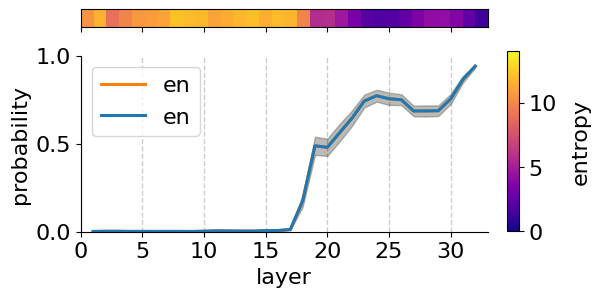

In [16]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

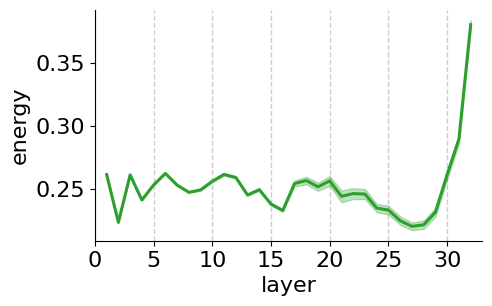

In [17]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')